In [1]:
import os, sys, numpy as np, time, random, warnings
import matplotlib.pyplot as plt

# Set up the source path (adjust as needed for your project)
notebooks_path = os.path.abspath(os.getcwd())
src_path = os.path.abspath(os.path.join(notebooks_path, "../src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import your custom functions (ensure these are accessible in your PYTHONPATH)
# Import your custom functions (including the markovian solvers)
from optimal_code.utils import *
from optimal_code.optimal_solver import *
from optimal_code.optimal_solver_markov import *
from trees.build_trees_from_paths import *
# Import modules
from trees.multi_dimension.Multidimension_trees import *
from trees.multi_dimension.Multidimension_adapted_empirical_measure import *
from adapted_empirical_measure.AEM_grid import *
from benchmark_value_gaussian.Comp_AWD2_Gaussian import *
from adapted_empirical_measure.AEM_grid import *
from trees.tree_Node import *
from trees.treeAnalysis import *
from trees.treeVisualization import *
from trees.tree_AWD_utilities import *
from trees.build_trees_from_paths import build_tree_from_paths
from trees.awd_trees.Discrete_OT_Solver_algo import *
from trees.awd_trees.Nested_Dist_Algo import *

from optimal_code.utils_multidim import *
from optimal_code.optimal_solver_multidim import *
from optimal_code.optimal_solver_multidim_markov import *

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# I tried with d = 5 you need HUGE amount of sample to converge -> (very long run times!!)

In [2]:
d=2
T=10
dim=d*T
var1 = 1.1**2
var2= 0.1**2

A = build_full_covariance(var1, d, T)
B = build_full_covariance(var2, d, T)

L = np.linalg.cholesky(A)
M = np.linalg.cholesky(B)

a, b = np.zeros(dim), np.zeros(dim)

print(adapted_wasserstein_squared_multidim(a, A, b, B, d, T))

109.99999999999999


In [3]:
sample_sizes = [5000, 10000, 15000, 25000, 50000, 100000, 200000]
fixed_grid = 0.1
n_runs = 10

In [4]:
results = {}  # Dictionary to store results keyed by sample size

for n_sample in sample_sizes:
    distances_runs = np.zeros(n_runs)
    times_runs = np.zeros(n_runs)
    
    print(f"\nRunning experiments for sample size: {n_sample}")
    
    for run in range(n_runs):
        # Generate two different random seeds (one for each matrix)
        seed1 = np.random.randint(10000)
        #seed2 = np.random.randint(10000)
        #while seed2 == seed1:  # Ensure they are different
            #seed2 = np.random.randint(10000)
        
        # Generate sample paths:
        # Process X (using matrix L) with seed1
        X, A = Lmatrix2paths_flat(L, n_sample, d, T, seed=seed1, verbose=False)
        Y, B = Lmatrix2paths_flat(M, n_sample, d, T, seed=seed1, verbose=False)
        
        # Compute the theoretical benchmark distance
        benchmark = adapted_wasserstein_squared_multidim(a, A, b, B, d, T)
        
        # Convert paths to adapted versions using the fixed grid
        adaptedX = path2adaptedpath_multidim(X, delta_n=fixed_grid)
        adaptedY = path2adaptedpath_multidim(Y, delta_n=fixed_grid)
        
        # Build quantization mapping:
        # Reshape the data so that we obtain a list of all ℝ² points:
        # adaptedX: shape (T+1, n_sample, d) -> (n_sample, T+1, d)
        points_X = adaptedX.transpose(1,0,2).reshape(-1, d)
        points_Y = adaptedY.transpose(1,0,2).reshape(-1, d)
        # Use np.unique along axis=0 to get unique grid points in ℝ².
        q2v = np.unique(np.concatenate([points_X, points_Y], axis=0), axis=0)
        # Convert each unique row (a 2D vector) to a tuple so it can be used as a key.
        q2v_list = [tuple(row) for row in q2v]
        v2q = {val: i for i, val in enumerate(q2v_list)}


                
        # Quantize each path: iterate over sample paths.
        # Resulting qX will have shape (n_sample, T+1) with integer entries.
        qX = np.array([[v2q[tuple(x)] for x in sample] 
                        for sample in adaptedX.transpose(1,0,2)])
        qY = np.array([[v2q[tuple(x)] for x in sample] 
                        for sample in adaptedY.transpose(1,0,2)])
        
        # Sort the quantized paths lexicographically (as in your 1D code)
        qX = sort_qpath_multidim(qX.T)
        qY = sort_qpath_multidim(qY.T)
        
        # Build conditional distributions from the quantized paths.
        mu_x = qpath2mu_x_markovian_multidim(qX)
        nu_y = qpath2mu_x_markovian_multidim(qY)
        (mu_x_c, mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn, v2q_x, mu_x_idx) = \
            list_repr_mu_x_markovian_multidim(mu_x, q2v)
        (nu_y_c, nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn, v2q_y, nu_y_idx) = \
            list_repr_mu_x_markovian_multidim(nu_y, q2v)
        
        # Compute the numerical adapted Wasserstein squared distance.
        t_start = time.perf_counter()
        AW_2square = nested2_parallel_markovian_multidim(mu_x_cn, mu_x_v, mu_x_w, mu_x_idx,
                                        nu_y_cn, nu_y_v, nu_y_w, nu_y_idx,
                                        n_processes=40, power=2)
        elapsed = time.perf_counter() - t_start
        
        distances_runs[run] = AW_2square
        times_runs[run] = elapsed
        
        print(f"Sample size {n_sample}, Run {run+1}: AW_2^2 = {AW_2square:.4f}, Time = {elapsed:.4f} s")
    
    # Store the results for the current sample size
    results[n_sample] = {"distances": distances_runs,
                         "times": times_runs,
                         "benchmark": benchmark}


Running experiments for sample size: 5000
Sample size 5000, Run 1: AW_2^2 = 121.2795, Time = 10.7857 s
Sample size 5000, Run 2: AW_2^2 = 121.1205, Time = 10.8689 s
Sample size 5000, Run 3: AW_2^2 = 123.3813, Time = 11.3520 s
Sample size 5000, Run 4: AW_2^2 = 119.7838, Time = 10.6640 s
Sample size 5000, Run 5: AW_2^2 = 123.9166, Time = 11.6288 s
Sample size 5000, Run 6: AW_2^2 = 120.9362, Time = 11.6027 s
Sample size 5000, Run 7: AW_2^2 = 121.4378, Time = 11.2858 s
Sample size 5000, Run 8: AW_2^2 = 122.3059, Time = 11.6657 s
Sample size 5000, Run 9: AW_2^2 = 122.9903, Time = 11.3434 s
Sample size 5000, Run 10: AW_2^2 = 120.5611, Time = 11.6033 s

Running experiments for sample size: 10000
Sample size 10000, Run 1: AW_2^2 = 120.6557, Time = 20.9081 s
Sample size 10000, Run 2: AW_2^2 = 121.3662, Time = 21.8367 s
Sample size 10000, Run 3: AW_2^2 = 119.2949, Time = 22.8959 s
Sample size 10000, Run 4: AW_2^2 = 117.9202, Time = 19.4299 s
Sample size 10000, Run 5: AW_2^2 = 119.4173, Time = 21


Aggregated Results:
Sample Size: 5000
  Mean AW_2^2: 121.7713 ± 1.2592
  Mean Time: 11.2800 s ± 0.3579 s
  Mean Absolute Error: 11.7713 ± 1.2592
  Benchmark: 110.0000

Sample Size: 10000
  Mean AW_2^2: 119.3878 ± 0.9820
  Mean Time: 20.9865 s ± 0.9548 s
  Mean Absolute Error: 9.3878 ± 0.9820
  Benchmark: 110.0000

Sample Size: 15000
  Mean AW_2^2: 118.7989 ± 0.4802
  Mean Time: 30.8608 s ± 1.7959 s
  Mean Absolute Error: 8.7989 ± 0.4802
  Benchmark: 110.0000

Sample Size: 25000
  Mean AW_2^2: 116.8400 ± 0.8282
  Mean Time: 48.7209 s ± 2.4146 s
  Mean Absolute Error: 6.8400 ± 0.8282
  Benchmark: 110.0000

Sample Size: 50000
  Mean AW_2^2: 115.0702 ± 0.3349
  Mean Time: 78.8585 s ± 3.8966 s
  Mean Absolute Error: 5.0702 ± 0.3349
  Benchmark: 110.0000

Sample Size: 100000
  Mean AW_2^2: 113.7312 ± 0.2727
  Mean Time: 119.3729 s ± 2.6088 s
  Mean Absolute Error: 3.7312 ± 0.2727
  Benchmark: 110.0000

Sample Size: 200000
  Mean AW_2^2: 112.6517 ± 0.1603
  Mean Time: 200.5002 s ± 6.3934 s
 

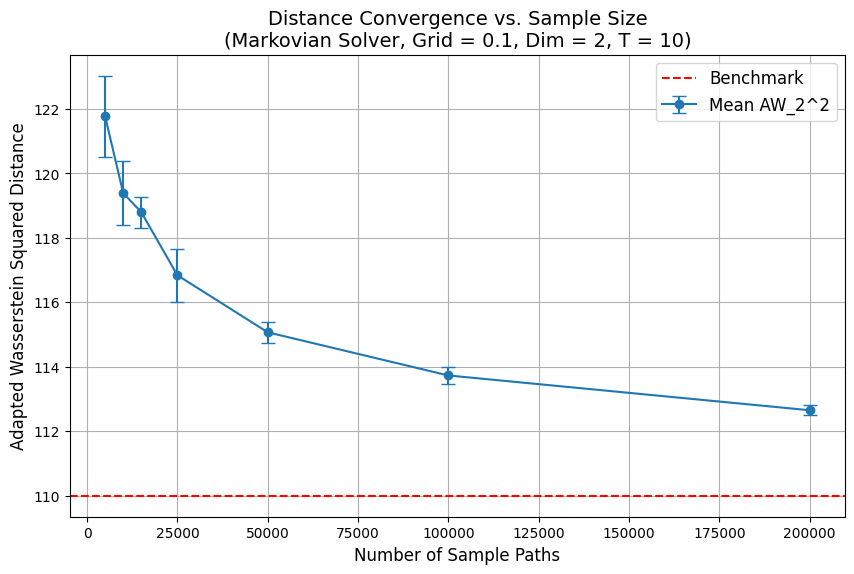

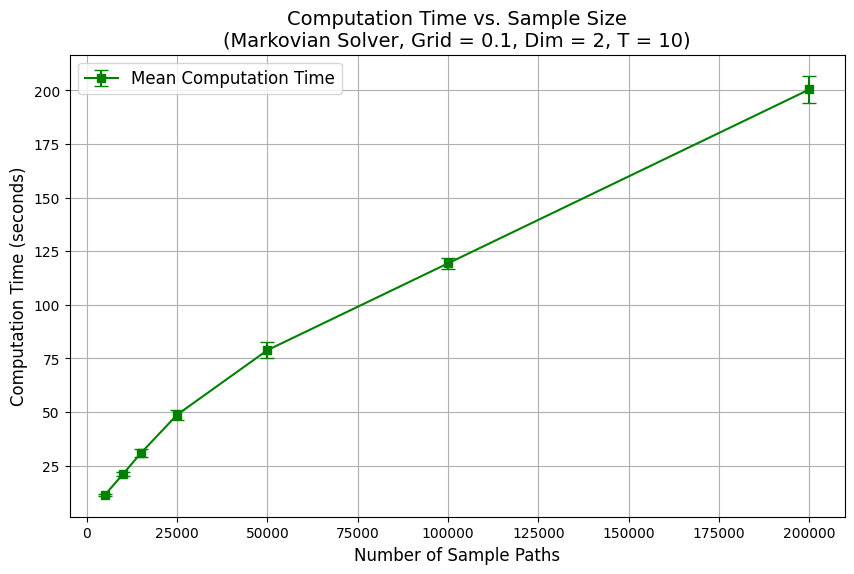

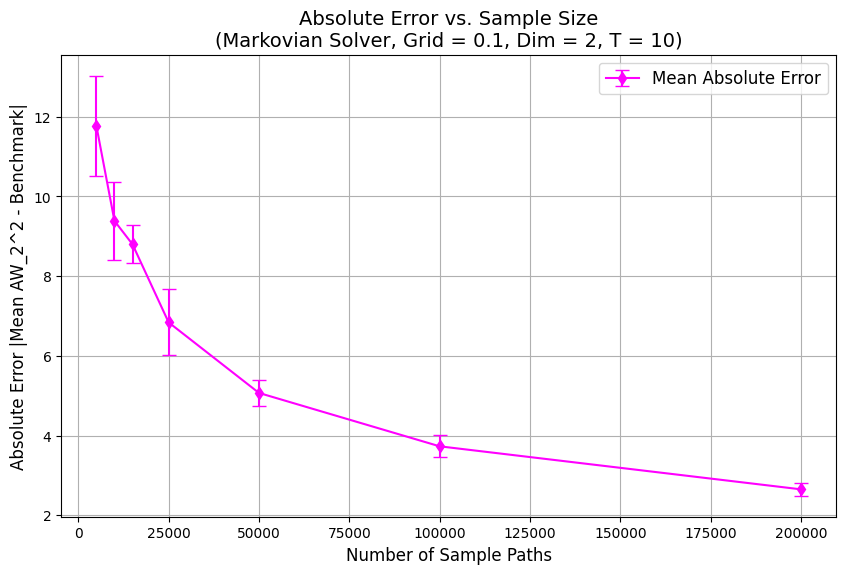

In [5]:

print("\nAggregated Results:")
aggregated = {}
for n_sample in sorted(results.keys()):
    data = results[n_sample]
    dists = data["distances"]
    times = data["times"]
    bench = data["benchmark"]
    mean_dist = np.mean(dists)
    std_dist = np.std(dists)
    mean_time = np.mean(times)
    std_time = np.std(times)
    abs_errors = np.abs(dists - bench)
    mean_abs_err = np.mean(abs_errors)
    std_abs_err = np.std(abs_errors)
    aggregated[n_sample] = {
        "mean_distance": mean_dist,
        "std_distance": std_dist,
        "mean_time": mean_time,
        "std_time": std_time,
        "mean_abs_error": mean_abs_err,
        "std_abs_error": std_abs_err,
        "benchmark": bench
    }
    print(f"Sample Size: {n_sample}")
    print(f"  Mean AW_2^2: {mean_dist:.4f} ± {std_dist:.4f}")
    print(f"  Mean Time: {mean_time:.4f} s ± {std_time:.4f} s")
    print(f"  Mean Absolute Error: {mean_abs_err:.4f} ± {std_abs_err:.4f}")
    print(f"  Benchmark: {bench:.4f}\n")


sample_list = sorted(aggregated.keys())
mean_distances = [aggregated[n]["mean_distance"] for n in sample_list]
std_distances = [aggregated[n]["std_distance"] for n in sample_list]
mean_times = [aggregated[n]["mean_time"] for n in sample_list]
std_times = [aggregated[n]["std_time"] for n in sample_list]
mean_abs_errors = [aggregated[n]["mean_abs_error"] for n in sample_list]
std_abs_errors = [aggregated[n]["std_abs_error"] for n in sample_list]
benchmark_val = aggregated[sample_list[0]]["benchmark"]

# Plot 1: Distance Convergence
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_distances, yerr=std_distances, fmt="o-", capsize=5, label="Mean AW_2^2")
plt.axhline(y=benchmark_val, color="red", linestyle="--", label="Benchmark")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Adapted Wasserstein Squared Distance", fontsize=12)
plt.title("Distance Convergence vs. Sample Size\n(Markovian Solver, Grid = 0.1, Dim = 2, T = 10)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 2: Computation Time
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_times, yerr=std_times, fmt="s-", capsize=5, color="green", label="Mean Computation Time")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Computation Time (seconds)", fontsize=12)
plt.title("Computation Time vs. Sample Size\n(Markovian Solver, Grid = 0.1, Dim = 2, T = 10)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 3: Absolute Error
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_abs_errors, yerr=std_abs_errors, fmt="d-", capsize=5, color="magenta", label="Mean Absolute Error")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Absolute Error |Mean AW_2^2 - Benchmark|", fontsize=12)
plt.title("Absolute Error vs. Sample Size\n(Markovian Solver, Grid = 0.1, Dim = 2, T = 10)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()